### In this notebook we show how to compute historical volatility* (aka realized volatility) and see how it relates to implied volatility using ticker SPY and CBOE's ^VIX

\* standard deviation is computed over 1 month (21 business days)

In [93]:
# reading materials / references
# 
# Wiki pages
# https://en.wikipedia.org/wiki/Volatility_(finance)
# https://en.wikipedia.org/wiki/Implied_volatility
# https://en.wikipedia.org/wiki/VIX
#
# CBOE implied volatility white paper
# https://www.cboe.com/micro/vix/vixwhite.pdf
#
# more from cboe
# https://www.cboe.com/institutional/pdf/parametric-volatility-risk-premium-and-financial-distress-2016-ca.pdf
# http://www.cboe.com/index/dashboard/SVRPO#svrpo-overview
#
# QuantConnect's volatility article
# https://www.quantconnect.com/tutorials/introduction-to-options/historical-volatility-and-implied-volatility
#
# replicating CBOE IV computation in QuantConnect
# https://www.quantconnect.com/forum/discussion/7882/front-month-implied-volatility

In [94]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [106]:
# get historical daily price for SPY and ^VIX
spy_history = yf.Ticker('SPY').history(period="max")
vix_history = yf.Ticker('^VIX').history(period="max")

In [107]:
vix = vix_history[['Close']]
vix = vix.rename(columns={"Close": "vix"})

# compute historical volatility.
df=pd.DataFrame()
df['volume'] = spy_history.Volume
df['price'] = spy_history.Close
df['pct_chg'] = df.price.pct_change()
# log return computation
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
df['ret_mean'] = df.log_ret.rolling(21).mean()
# will stick with log return but using a window of 21
# https://en.wikipedia.org/wiki/Volatility_(finance) "annualized vol" but looking back only 21 days
df['hist_vol'] = df.log_ret.rolling(21).std()*np.sqrt(252)*100
# merge with vix
df = pd.merge(df,vix,how='left',on=['Date'])
org_df = df.dropna()

df = org_df[['hist_vol','vix']]

plot the volatilities through time.


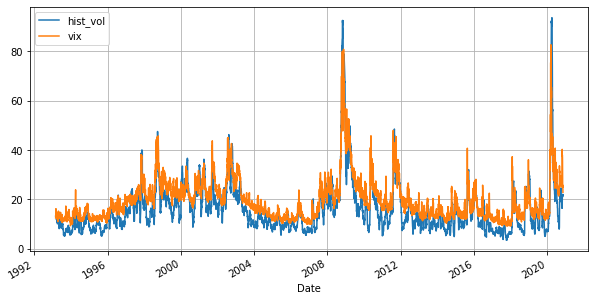

In [108]:
df.plot(figsize=(10,5))
plt.grid(True)
print("plot the volatilities through time.")

plot the volatilities through time past 1 year.


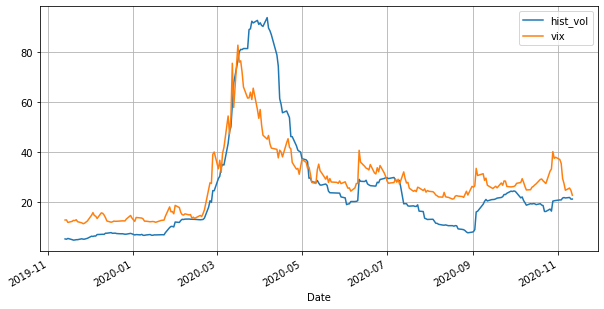

In [125]:
df.iloc[-252:].plot(figsize=(10,5))
plt.grid(True)
print("plot the volatilities through time past 1 year.")

plotting realized against implied volatility


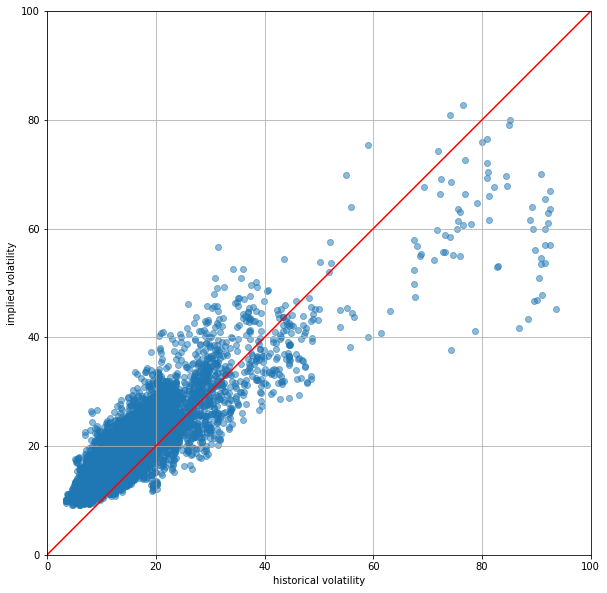

In [126]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot([0,100],[0,100],color='red') # identity
plt.scatter(df.hist_vol, df.vix,alpha=0.5)
plt.xlim(0,100)
plt.ylim(0,100)
ax.set_aspect(1)
plt.xlabel('historical volatility')
plt.ylabel('implied volatility')
plt.grid(True)
print('plotting realized against implied volatility')

another way to visualize the 2 time series is to look at the distribution of the ratio between to volatilities.


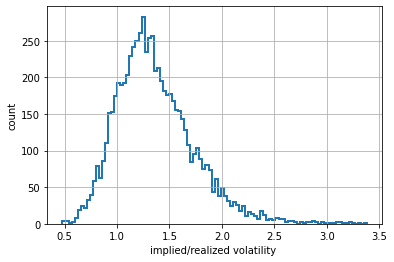

In [127]:
_ = plt.hist((df.vix/df.hist_vol).values,bins=100,histtype='step',linewidth=2)
plt.xlabel('implied/realized volatility ')
plt.ylabel('count')
plt.grid(True)
print('another way to visualize the 2 time series is to look at the distribution of the ratio between to volatilities.')

In [128]:
total_count = len((df.vix/df.hist_vol).values)
higher_count = np.sum((df.vix/df.hist_vol).values>1)
print(f'percentage of ratio > 1: {100*higher_count/total_count:1.2f}%')

percentage of ratio > 1: 85.34%


#### a few observations
+ implied and realized volatilities track closely.

+ there are more occurences (85% of the time) when implied vol is higher than realized volatility.

+ per black-scholes-merton model, volatility is one variable that determine option prices, thus since 85% of the time, realized volatility is lower than the implied volatility,
  ( *** disclaimer. we are looking at just the SPY! ***)
  selling options while maintaining a neutural price movement should have a higher chance of sucess.
  This is historically true, and is one of the "edge" used by hedge funds & market makers.

+ CBOE actually have an index: "Cboe S&P 500 Market-Neutral Volatility Risk Premia Optimized Index (SVRPO)" that show the performance on harvesting this "volatility risk premium". http://www.cboe.com/index/dashboard/SVRPO#svrpo-performance

#### on a related note...

+  ^VIX (or in Tasty `/VX`) is defined to track the 1 month implied volatility (IV) - thus using weighted prices from option chain (front and back) that is near the 30 day-to-expiration.  Thus, you can always compute the 1-month, 2-month, 3-month IVs to track how market is predicting if volatility is going to expand/contract in the future.  Luckily, CBOE actual provides 2 indices for you to track and trade, VXX, VXZ.*  Where VXX tracks the "first and second month of VIX futures contracts", while VXZ tracks "the fourth, fifth, sixth and seventh month VIX futures contracts".

#### references

http://www.cboe.com/products/options-on-single-stocks-and-exchange-traded-products/options-on-exchange-traded-products/cboe-options-on-volatility-based-etps

https://www.ipathetn.com/US/16/en/details.app?instrumentId=341408

https://www.ipathetn.com/US/16/en/details.app?instrumentId=341615

In [158]:
# get historical daily price for SPY and ^VIX
spy_history = yf.Ticker('SPY').history(period="max")
vix_history = yf.Ticker('^VIX').history(period="max")
vxx_history = yf.Ticker('VXX').history(period="max")
vxz_history = yf.Ticker('VXZ').history(period="max")

vix = vix_history[['Close']]
vix = vix.rename(columns={"Close": "vix"})

vxx = vxx_history[['Close']]
vxx = vxx.rename(columns={"Close": "vxx"})

vxz = vxz_history[['Close']]
vxz = vxz.rename(columns={"Close": "vxz"})

# compute historical volatility.
df=pd.DataFrame()
df['volume'] = spy_history.Volume
df['price'] = spy_history.Close
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
df['ret_mean'] = df.log_ret.rolling(21).mean()
# will stick with log return but using a window of 21
# https://en.wikipedia.org/wiki/Volatility_(finance) "annualized vol" but looking back only 21 days
df['hist_vol'] = df.log_ret.rolling(21).std()*np.sqrt(252)*100
# merge with vix
df = pd.merge(df,vix,how='left',on=['Date'])
df = pd.merge(df,vxx,how='left',on=['Date'])
df = pd.merge(df,vxz,how='left',on=['Date'])
org_df = df.dropna()

df = org_df[['hist_vol','vix','vxx','vxz']]

plot the volatilities through time.


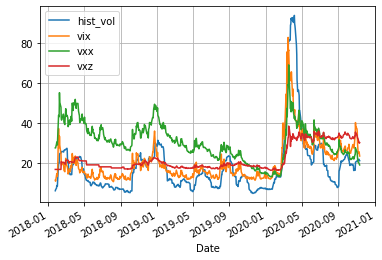

In [160]:
df.plot()
plt.grid(True)
print("plot the volatilities through time.")